#### Study notes for Data loading and processing 
This is the study notes from [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html]


In [1]:
from __future__ import print_function, division
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
plt.ion()


PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [2]:
# Eable local module access
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
print("Module Path: ", module_path)


Module Path:  /data/study/torch-1.0/pytorch-study-notes


In [3]:
# Import the Sample data type instead of relying on magic strings
from core.faces.typing import Sample, samples_to_dicts



In [4]:
# Top level dta directory. Here we assume the format of the directory conforms
data_dir = "./data/faces"
csv_file_name = os.path.join(data_dir, "face_landmarks.csv")
landmarks_frame=pd.read_csv(f'{data_dir}/face_landmarks.csv')
n=65
img_name = landmarks_frame.iloc[n,0]
landmarks = landmarks_frame.iloc[n,1:].values
landmarks = landmarks.astype('float').reshape(-1,2)

print(f"Image name: {img_name}")
print(f"Landmarks shape: {landmarks.shape}")
print(f"First 4 Landmarks: {landmarks[:4]}")


Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


**A helper function to show an image and its landmarks and use it to show a sample**

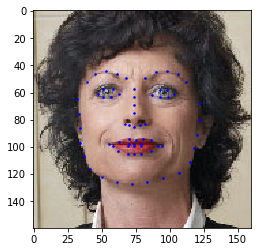

In [5]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:,1], s=10, marker='.', c='b')
    plt.pause(0.001) # wait for plots to update

plt.figure()
show_landmarks(io.imread(os.path.join(data_dir, img_name)), landmarks)
plt.show()

0 (324, 215, 3) (68, 2)


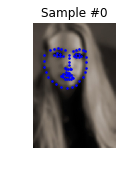

1 (500, 333, 3) (68, 2)


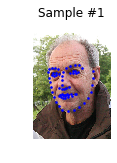

2 (250, 258, 3) (68, 2)


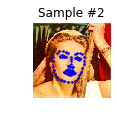

3 (434, 290, 3) (68, 2)


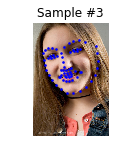

In [6]:
from core.faces.face_landmark_dataset import FaceLandmarksDataset
face_dataset = FaceLandmarksDataset(
    csv_file=csv_file_name,
    root_dir=data_dir
)
fig = plt.figure()
for i,sample in enumerate(face_dataset):
    print(i, sample.image.shape, sample.landmarks.shape)
    ax = plt.subplot(1,4, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}")
    ax.axis('off')
    show_landmarks(sample.image, sample.landmarks)
    
    if i is 3:
        plt.show()
        break

#### TRANSFORMS
One issue we have is that the samples are no tof the same size. Most neural networks   
  expect the images of a fixed size. Therefore, we will need to process the images
  * `Rescale`: to scale the image
  * `RandomCrop`: to crop from image randomly. This is data augmentation.
  * `ToTenser`: to convert the numpy images to torch images( we need to swap axes).
  
We will implment them as callable classes instead of functions so that parameters of the   
  transform need not be passed everytime it's called. We can then use a transform like this:
  
  ```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)

   ```


In [7]:
from core.faces.transform_funcs import Rescale, RandomCrop, ToTensor




/home/weima/anaconda3/envs/torch-1.0/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/weima/anaconda3/envs/torch-1.0/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


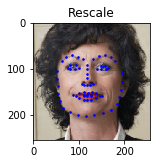

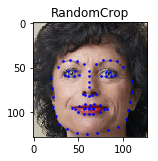

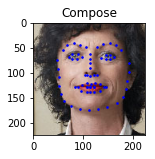

In [8]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([
    Rescale(256),
    RandomCrop(224)
])
fig = plt.figure()
sample = face_dataset[65]

for i, tsfrm in enumerate((scale,crop, composed)):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(transformed_sample.image, transformed_sample.landmarks)
    

In [9]:
transform = transforms.Compose([
    Rescale(256),
    RandomCrop(224),
    ToTensor()
])

transformed_samples = [transform(sample) for sample in face_dataset]
for i, sample in enumerate(transformed_samples):
    print(i, sample.image.shape,  sample.landmarks.shape)
    if i == 3:
        break

0 (3, 224, 224) (68, 2)
1 (3, 224, 224) (68, 2)
2 (3, 224, 224) (68, 2)
3 (3, 224, 224) (68, 2)


### USING BUILT-IN DataLoader class

Using a simple for loop to iterate over data are missing features
  * Batching data
  * Shuffling data
  * Load data in parallel using `multiprocessing` workers
  
`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used   
  below should be clear. One parameter of interest is `collate_fn`. One can specify how exactly  
  the samples need to be batched using `collate_fn`. 

In [10]:
from torch.utils.data import DataLoader
dict_dataset = list(samples_to_dicts(transformed_samples))
dataloader = DataLoader(dict_dataset, batch_size=4, shuffle=True, num_workers=4)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
IBatch:torch.Size([4, 3, 224, 224]), LBatch:torch.Size([4, 68, 2])


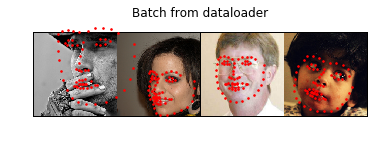

In [23]:
from torchvision import utils
def show_landmarks_batch(image, landmarks):
    print(f'IBatch:{image.shape}, LBatch:{landmarks.shape}')
    images_batch, landmarks_batch = image, landmarks
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')
    

for i_batch, sample_batched in enumerate(dataloader):
    print(
        i_batch, 
        sample_batched['image'].shape,
        sample_batched['landmarks'].shape
         
    )
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(**sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
       
       